# **notebook_03: Veri Hikayesi Anlatımı**

**1. Rol & Amaç**

Bu notebook’ta, enerji perakende verileri kullanılarak:
- İlçeler arası tüketim farkları,
- Müşteri segmentleri,
- Tahsilat performansı
bir veri bilimci bakış açısıyla analiz edilmiştir.

Her analiz aşağıdaki yapı ile sunulmaktadır:

**Problem Tanımı → Hipotezler → Analiz & Görseller → Bulgular → İş Önerileri**

Amaç yalnızca veriyi incelemek değil, iş kararlarını destekleyecek içgörüler üretmektir.

**2. Kütüphanelerin ve Verilerin Yüklenmesi**

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df_tahakkuk_all = pd.read_pickle("tahakkuk_clean.pkl")
df_tahsilat = pd.read_pickle("tahsilat_clean.pkl")
df_tahsilat_1 = pd.read_pickle("tahsilat1_clean.pkl")

sns.set_theme(style="whitegrid", context="talk")
plt.rcParams["font.family"] = "DejaVu Sans"

In [53]:
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap

mpl.rcParams.update(mpl.rcParamsDefault)
sns.set_theme(style="whitegrid", context="notebook")

mpl.rcParams.update({
    "figure.dpi": 150,
    "savefig.dpi": 300,
    "axes.titlesize": 13,
    "axes.labelsize": 11,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
})

In [54]:
from pathlib import Path

OUT_DIR = Path("outputs/figures")
OUT_DIR.mkdir(parents=True, exist_ok=True)

def save_fig(filename: str, dpi: int = 300, close: bool = False):
    plt.tight_layout()
    plt.savefig(
        OUT_DIR / filename,
        dpi=dpi,
        bbox_inches="tight",
        facecolor="white",
        pad_inches=0.05
    )
    if close:
        plt.close()

**3. İlçe Karşılaştırma Analizi**

**Problem Tanımı**

İlçeler arasında enerji tüketimi, müşteri yapısı ve mevsimsel dalgalanmalar açısından belirgin farklılıklar bulunmaktadır. Bu farklılıkların hangi yapısal faktörlerden kaynaklandığını anlamak; altyapı planlaması, tarife tasarımı ve risk yönetimi için kritik öneme sahiptir.

**Hipotezler**

- Ticari ve tarımsal abonelerin yoğun olduğu ilçelerde tüketim seviyeleri daha yüksektir.
- Mesken ağırlıklı ilçelerde tüketim daha düşük ve daha stabildir.
- Bazı ilçelerde mevsimsel (yaz–kış) tüketim farkı diğerlerine göre daha belirgindir.
- Tüketim dalgalanma düzeyi yüksek olan ilçeler operasyonel açıdan daha risklidir.

**Analiz**

In [55]:
hs_col = "hesap_sinifi" if "hesap_sinifi" in df_tahakkuk_all.columns else ("Hesap Sınıfı" if "Hesap Sınıfı" in df_tahakkuk_all.columns else None)

if hs_col is None:
    raise ValueError("Hesap sınıfı sütunu bulunamadı.")

ilce_hesap_sinifi = (
    df_tahakkuk_all
    .groupby(["ilce", hs_col])
    .size()
    .reset_index(name="kayit_sayisi")
)

ilce_toplam = ilce_hesap_sinifi.groupby("ilce")["kayit_sayisi"].sum().reset_index(name="toplam")
ilce_hesap_sinifi = ilce_hesap_sinifi.merge(ilce_toplam, on="ilce", how="left")
ilce_hesap_sinifi["oran"] = ilce_hesap_sinifi["kayit_sayisi"] / ilce_hesap_sinifi["toplam"]

dagılım = (
    ilce_hesap_sinifi
    .sort_values(["ilce", "oran"], ascending=[True, False])
    .groupby("ilce")
    .head()
)

dagılım

,ilce,hesap_sinifi,kayit_sayisi,toplam,oran
4,GÖYNÜCEK,M001,257738,295223,0.873028
12,GÖYNÜCEK,T001,20230,295223,0.068524
5,GÖYNÜCEK,M002,2990,295223,0.010128
25,GÖYNÜCEK,TA01,2618,295223,0.008868
22,GÖYNÜCEK,T019,2146,295223,0.007269
37,GÜMÜŞHACIKÖY,M001,658189,765657,0.859639
46,GÜMÜŞHACIKÖY,T001,63600,765657,0.083066
61,GÜMÜŞHACIKÖY,TA01,13987,765657,0.018268
38,GÜMÜŞHACIKÖY,M002,5740,765657,0.007497
47,GÜMÜŞHACIKÖY,T002,5053,765657,0.006600


In [56]:
hs_series = (
    df_tahakkuk_all[hs_col]
    .astype(str)
    .str.strip()
    .replace({"nan": "Bilinmiyor", "None": "Bilinmiyor"})
)

hs_counts = hs_series.value_counts(dropna=False)
hs_ratio  = (hs_counts / hs_counts.sum() * 100)

hs_table = (
    pd.DataFrame({
        "Hesap Sınıfı": hs_counts.index,
        "Adet": hs_counts.values,
        "Oran (%)": hs_ratio.values
    })
    .assign(**{"Oran (%)": lambda d: d["Oran (%)"].round(2)})
)

display(hs_table.head(15))

ilce_col = "ilce"

ilce_series = (
    df_tahakkuk_all[ilce_col]
    .astype(str)
    .str.strip()
    .str.upper()
)

,Hesap Sınıfı,Adet,Oran (%)
0,M001,1026609,86.58
1,T001,91298,7.70
2,TA01,17266,1.46
3,M002,10173,0.86
4,T019,8500,0.72
5,T002,6706,0.57
6,T021,3505,0.30
7,A001,3189,0.27
8,SE01,2671,0.23
9,T013,2460,0.21


In [57]:
df_season = df_tahakkuk_all.dropna(subset=["mali_yil_donem"]).copy()
df_season["ay"] = df_season["mali_yil_donem"].dt.month

monthly = (
    df_season
    .groupby(["ilce", "ay"])["kwh"]
    .mean()
    .reset_index()
)

season_strength = (
    monthly
    .groupby("ilce")["kwh"]
    .agg(min_aylik="min", max_aylik="max")
    .assign(mevsimsellik_genisligi=lambda d: d["max_aylik"] - d["min_aylik"])
    .sort_values("mevsimsellik_genisligi", ascending=False)
    .reset_index()
)

season_strength

,ilce,min_aylik,max_aylik,mevsimsellik_genisligi
0,GÖYNÜCEK,66.219465,140.941444,74.721979
1,GÜMÜŞHACIKÖY,83.659150,140.082910,56.423760
2,HAMAMÖZÜ,65.242653,78.383162,13.140510


In [58]:
fatura_stats = (
    df_tahakkuk_all
    .groupby("ilce")["kwh"]
    .agg(
        kayit_sayisi="size",
        std_kwh="std"
    )
)

musteri = (
    df_tahakkuk_all
    .groupby("ilce")["sozlesme_hesap_no"]
    .nunique()
    .rename("musteri_sayisi")
)

tuketim = (
    df_tahakkuk_all
    .groupby("ilce")["kwh"]
    .agg(["mean", "median"])
    .rename(columns={"mean": "ortalama_kwh", "median": "medyan_kwh"})
)

tuketim_kisi = (
    df_tahakkuk_all
    .groupby("ilce")["kwh"]
    .sum() / musteri
).rename("kisi_basi_kwh")

outlier_orani = (
    df_tahakkuk_all
    .groupby("ilce")["is_outlier"]
    .mean()
    .rename("outlier_orani")
)

df_tahakkuk_all["ay"] = df_tahakkuk_all["mali_yil_donem"].dt.month

mevsim = (
    df_tahakkuk_all
    .groupby(["ilce", "ay"])["kwh"]
    .mean()
    .groupby("ilce")
    .apply(lambda x: x.max() - x.min())
    .rename("mevsimsellik_genisligi")
)

ilce_profili = pd.concat(
    [fatura_stats, musteri, tuketim, tuketim_kisi, outlier_orani, mevsim],
    axis=1
).reset_index()

ilce_profili["ortalama_kwh"] = ilce_profili["ortalama_kwh"].round(2)
ilce_profili["medyan_kwh"] = ilce_profili["medyan_kwh"].round(2)
ilce_profili["kisi_basi_kwh"] = ilce_profili["kisi_basi_kwh"].round(2)
ilce_profili["std_kwh"] = ilce_profili["std_kwh"].round(2)
ilce_profili["outlier_orani"] = (ilce_profili["outlier_orani"] * 100).round(2)

ilce_profili

,ilce,kayit_sayisi,std_kwh,musteri_sayisi,ortalama_kwh,medyan_kwh,kisi_basi_kwh,outlier_orani,mevsimsellik_genisligi
0,GÖYNÜCEK,295223,742.28,7128,89.67,45.09,3713.89,4.19,74.721979
1,GÜMÜŞHACIKÖY,765657,1077.76,18190,97.34,48.31,4097.11,4.16,56.423760
2,HAMAMÖZÜ,124818,389.22,2981,70.87,40.56,2967.60,3.49,13.140510


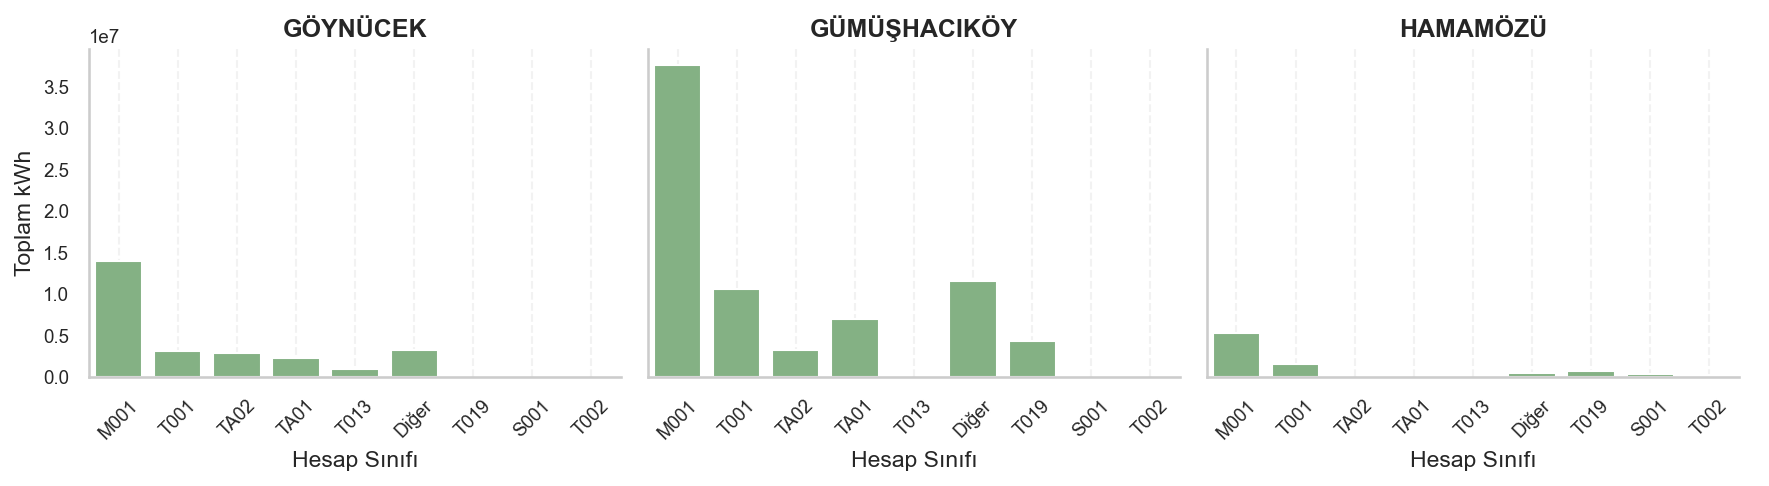

In [59]:
hs = (
    df_tahakkuk_all
    .groupby(["ilce", "hesap_sinifi"], as_index=False)["kwh"]
    .sum()
)

parts = []
for ilce_name, g in hs.groupby("ilce", sort=False):
    g = g.sort_values("kwh", ascending=False).copy()

    top5 = g.head(5).copy()
    other_sum = g.iloc[5:]["kwh"].sum()

    if other_sum > 0:
        other_row = pd.DataFrame({
            "ilce": [ilce_name],
            "hesap_sinifi": ["Diğer"],
            "kwh": [other_sum]
        })
        top5 = pd.concat([top5, other_row], ignore_index=True)

    parts.append(top5)

hs_clean = pd.concat(parts, ignore_index=True)  

g = sns.catplot(
    data=hs_clean,
    x="hesap_sinifi",
    y="kwh",
    col="ilce",
    kind="bar",
    col_wrap=3,
    height=3.4,      
    aspect=1.15,     
    color="#7CB87C"
)

g.set_titles("{col_name}", size=12, weight="bold")
g.set_axis_labels("Hesap Sınıfı", "Toplam kWh")

for ax in g.axes.flat:
    ax.tick_params(axis="x", rotation=45, labelsize=9)
    ax.tick_params(axis="y", labelsize=9)

    ax.grid(axis="y", visible=False)
    ax.grid(axis="x", linestyle="--", alpha=0.25)

    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)

plt.tight_layout()
save_fig("04_district_account_class_consumption.png") 
plt.show()

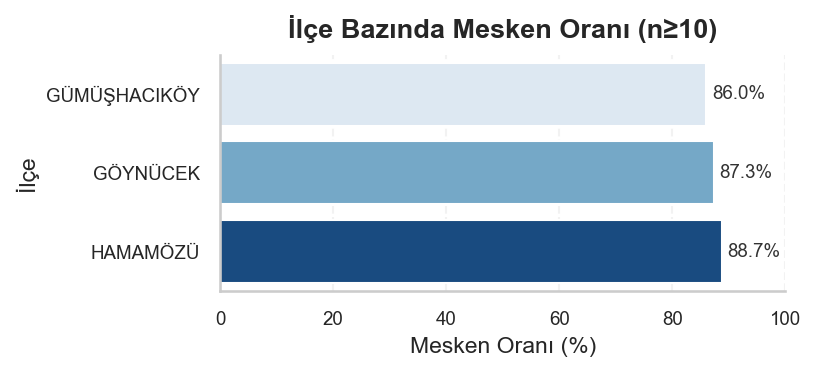

Mesken satır sayısı: 1026609 | Toplam satır: 1185698
Mesken genel oran (%): 86.58


In [60]:
ilce_col = next(c for c in ["ilce", "İlçe", "ILCE", "ilçe"] if c in df_tahakkuk_all.columns)

hs_name_col = next(
    c for c in ["Hesap Sınıfı", "Hesap Sinifi", "hesap_sinifi_adi", "hesap_sinifi_name", "hesap_sinifi"]
    if c in df_tahakkuk_all.columns
)

hs_series = (
    df_tahakkuk_all[hs_name_col]
    .astype(str)
    .str.strip()
    .str.upper()
)

ilce_series = (
    df_tahakkuk_all[ilce_col]
    .astype(str)
    .str.strip()
    .str.upper()
)

mesken_mask = hs_series.str.contains(r"\bMESKEN\b", na=False)

ilce_stats = (
    pd.DataFrame({"ilce": ilce_series, "is_mesken": mesken_mask})
      .groupby("ilce", as_index=False)["is_mesken"]
      .agg(is_mesken="mean", adet="size")
)

ilce_stats["mesken_oran"] = (ilce_stats["is_mesken"] * 100).round(1)
ilce_stats = ilce_stats.sort_values("mesken_oran", ascending=False)

MIN_N = 10
ilce_stats = ilce_stats[ilce_stats["adet"] >= MIN_N].copy()

denom = ilce_stats["mesken_oran"].max() - ilce_stats["mesken_oran"].min()
norm = (ilce_stats["mesken_oran"] - ilce_stats["mesken_oran"].min()) / (denom if denom != 0 else 1)

cmap = sns.color_palette("Blues", as_cmap=True)
colors = [cmap(0.15 + 0.75 * float(v)) for v in norm] 
color_map = dict(zip(ilce_stats["ilce"], colors))

fig_h = min(4.0, 1.5 + len(ilce_stats) * 0.38)
fig, ax = plt.subplots(figsize=(5.6, fig_h), dpi=150)

plot_df = ilce_stats.sort_values("mesken_oran", ascending=True)

sns.barplot(
    data=plot_df,
    x="mesken_oran",
    y="ilce",
    hue="ilce",
    palette=color_map,
    dodge=False,
    legend=False,
    ax=ax
)

ax.set_title(f"İlçe Bazında Mesken Oranı (n≥{MIN_N})",
             fontsize=13, fontweight="bold", pad=8)

ax.set_xlabel("Mesken Oranı (%)", fontsize=11)
ax.set_ylabel("İlçe", fontsize=11)
ax.set_xlim(0, 100)

ax.grid(axis="x", linestyle="--", alpha=0.25)
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

ax.tick_params(axis="x", labelsize=9)
ax.tick_params(axis="y", labelsize=9)

for i, v in enumerate(plot_df["mesken_oran"].values):
    ax.text(min(v + 1.0, 99.0), i, f"{v:.1f}%", va="center", fontsize=9, color="#333333")

plt.tight_layout()
plt.show()

print("Mesken satır sayısı:", int(mesken_mask.sum()), "| Toplam satır:", len(mesken_mask))
print("Mesken genel oran (%):", round(mesken_mask.mean() * 100, 2))

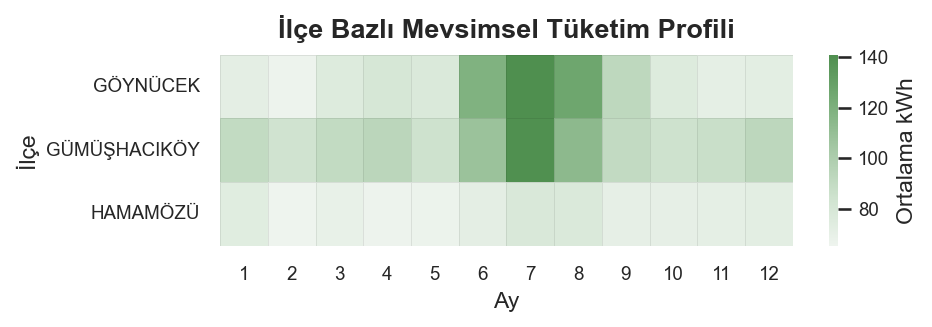

In [61]:
df_tmp = df_tahakkuk_all.copy()
df_tmp["mali_yil_donem"] = pd.to_datetime(df_tmp["mali_yil_donem"], errors="coerce")

season_pivot = (
    df_tmp
    .dropna(subset=["mali_yil_donem"])
    .assign(ay=lambda x: x["mali_yil_donem"].dt.month)
    .groupby(["ilce", "ay"], as_index=False)["kwh"]
    .mean()
    .pivot(index="ilce", columns="ay", values="kwh")
)

season_pivot = season_pivot.reindex(columns=range(1, 13))

n_rows = season_pivot.shape[0]
fig_h = min(4.5, 1.8 + n_rows * 0.18)  
fig, ax = plt.subplots(figsize=(6.5, fig_h), dpi=150)

pastel_green = LinearSegmentedColormap.from_list(
    "pastel_green",
    ["#EEF4EE", "#CFE3CF", "#A7C9A7", "#78AD78", "#4F8F4F"]
)

sns.heatmap(
    season_pivot,
    cmap=pastel_green,
    linewidths=0.4,
    linecolor=(0, 0, 0, 0.08),          
    cbar_kws={"label": "Ortalama kWh"},
    ax=ax
)

ax.set_title("İlçe Bazlı Mevsimsel Tüketim Profili", fontsize=13, fontweight="bold", pad=8)
ax.set_xlabel("Ay", fontsize=11)
ax.set_ylabel("İlçe", fontsize=11)

ax.tick_params(axis="x", labelsize=9)
ax.tick_params(axis="y", labelsize=9)

for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.show()

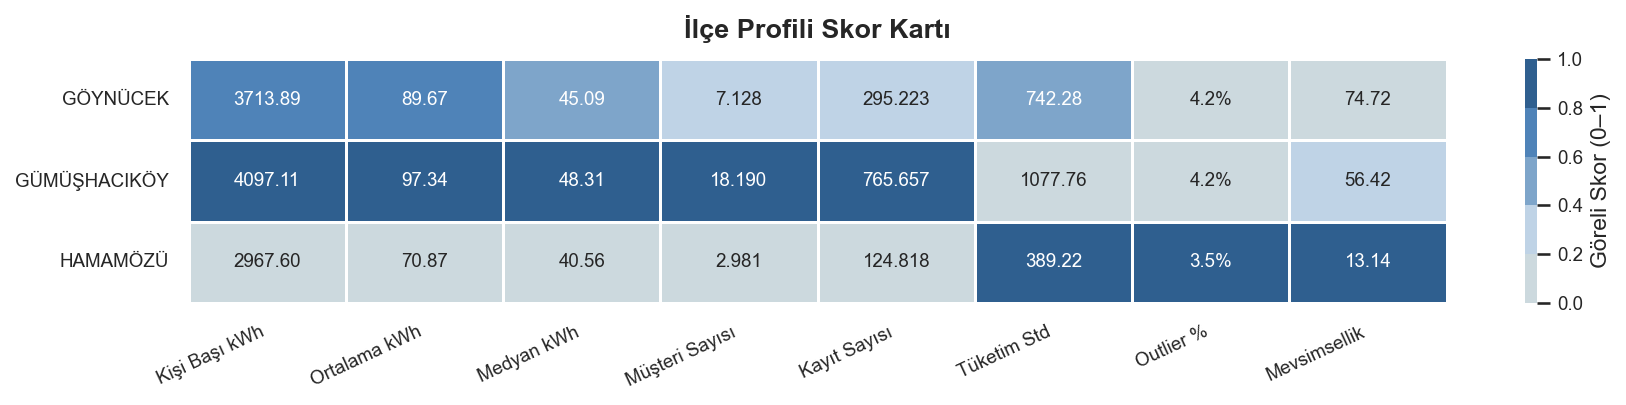

In [62]:
metrics = [
    "kisi_basi_kwh",
    "ortalama_kwh",
    "medyan_kwh",
    "musteri_sayisi",
    "kayit_sayisi",
    "std_kwh",
    "outlier_orani",
    "mevsimsellik_genisligi"
]

pretty_cols = {
    "kisi_basi_kwh": "Kişi Başı kWh",
    "ortalama_kwh": "Ortalama kWh",
    "medyan_kwh": "Medyan kWh",
    "musteri_sayisi": "Müşteri Sayısı",
    "kayit_sayisi": "Kayıt Sayısı",
    "std_kwh": "Tüketim Std",
    "outlier_orani": "Outlier %",
    "mevsimsellik_genisligi": "Mevsimsellik"
}

df_card = ilce_profili[["ilce"] + metrics].copy().set_index("ilce")

def minmax(s):
    s = pd.to_numeric(s, errors="coerce")
    denom = (s.max() - s.min())
    if denom == 0 or np.isnan(denom):
        return pd.Series(np.zeros(len(s)), index=s.index)
    return (s - s.min()) / denom

score = df_card.apply(minmax)

lower_is_better = ["std_kwh", "outlier_orani", "mevsimsellik_genisligi"]
for c in lower_is_better:
    if c in score.columns:
        score[c] = 1 - score[c]

score = score.rename(columns=pretty_cols)
df_show = df_card.rename(columns=pretty_cols)

def fmt_value(col, v):
    if pd.isna(v):
        return ""
    if col in ["Müşteri Sayısı", "Kayıt Sayısı"]:
        return f"{int(v):,}".replace(",", ".") 
    if col == "Outlier %":
        return f"{float(v):.1f}%"
    return f"{float(v):.2f}"

annot_text = df_show.copy()
for c in annot_text.columns:
    annot_text[c] = annot_text[c].apply(lambda v: fmt_value(c, v))

n_rows, n_cols = score.shape
fig_w = min(12, 6.8 + n_cols * 0.65)        
fig_h = min(6.0, 1.6 + n_rows * 0.42)       

fig, ax = plt.subplots(figsize=(fig_w, fig_h), dpi=150)

cmap = sns.color_palette(
    ["#CCD9DE", "#BFD3E6", "#7EA5CA", "#4F83B8", "#2F5F8F"],
    as_cmap=True
)

sns.heatmap(
    score,
    vmin=0, vmax=1,
    cmap=cmap,
    linewidths=0.7, linecolor="white",
    annot=annot_text.values, fmt="",          
    annot_kws={"fontsize": 9},
    cbar_kws={"label": "Göreli Skor (0–1)"},
    ax=ax
)

ax.set_title("İlçe Profili Skor Kartı",
             fontsize=13, fontweight="bold", pad=10)

ax.set_xlabel("")
ax.set_ylabel("")
ax.tick_params(axis="x", labelsize=9)
ax.tick_params(axis="y", labelsize=9)
plt.xticks(rotation=25, ha="right")
plt.yticks(rotation=0)

plt.tight_layout()
save_fig("05_district_scorecard.png") 
plt.show()

**Bulgular**

- İlçeler arasında toplam ve kişi başına tüketim seviyeleri anlamlı biçimde farklılaşmaktadır.  
- Ticari ağırlıklı ilçeler daha yüksek ve dalgalanmalı tüketim profiline sahiptir.
- Hesap sınıfı dağılımı (mesken, ticari, tarımsal) ilçelerin tüketim profilini belirleyen ana faktördür.
- Mevsimsellik bazı ilçelerde güçlü iken, bazıları yıl boyunca stabildir.
- Yüksek dalgalanma düzeyi ve outlier oranı olan ilçeler daha öngörülemez bir tüketim yapısına sahiptir.

**İş Önerileri**

- İlçeler, tüketim ve müşteri profiline göre segmentlere ayrılarak tarife ve tahsilat politikaları özelleştirilmelidir.
- Mevsimselliği yüksek ilçelerde dönemsel faturalama ve taksitlendirme modelleri uygulanmalıdır.
- Ticari yoğunluğu yüksek ilçeler altyapı ve operasyonel yatırımlarda önceliklendirilmelidir.
- Oluşturulan skor kartı, yatırım ve risk yönetimi için karar destek aracı olarak kullanılmalıdır.

**4. Müşteri Segmentasyonu**

**Problem Tanımı**

Müşteriler tüketim miktarı ve ödeme davranışı açısından homojen değildir. Bu farklılıkların segmentlere ayrılması, tahsilat yönetimi, risk kontrolü ve müşteri değerinin doğru yönetilmesi için gereklidir.

**Hipotezler**

- Yüksek tüketimli müşterilerde geç ödeme davranışı daha yüksek finansal risk yaratır. 
- Ödeme davranışı, tüketim seviyesine göre sistematik olarak farklılaşır.
- Müşteri aktivitesi tüketim ve ödeme davranışını birlikte güçlendirir.

**Segmentasyon**

In [63]:
def clean_columns(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = df.columns.str.strip()
    return df

def pick_col(df: pd.DataFrame, candidates: list[str], name_for_error: str):
    for c in candidates:
        if c in df.columns:
            return c
    raise KeyError(
        f"Kolon bulunamadı: {name_for_error}. "
        f"Adaylar: {candidates}. Mevcut kolonlar: {list(df.columns)}"
    )

def std_str(s: pd.Series) -> pd.Series:
    return s.astype(str).str.strip().str.upper()

def payment_any_positive(df: pd.DataFrame, cols: list[str]) -> pd.Series:
    exist = [c for c in cols if c in df.columns]
    if not exist:
        return pd.Series(False, index=df.index)

    x = df[exist].apply(pd.to_numeric, errors="coerce")
    return x.fillna(0).gt(0).any(axis=1)

In [64]:
df_tahakkuk_all = clean_columns(df_tahakkuk_all)
df_tahsilat_1   = clean_columns(df_tahsilat_1)

In [65]:
col_ilce_tah = pick_col(df_tahakkuk_all, ["ilce", "İlçe", "ILCE", "ilçe"], "Tahakkuk ilçe")
col_soz_tah  = pick_col(df_tahakkuk_all, ["sozlesme_hesap_no", "Söz.hsp.(bağımsız)", "sozlesme_no"], "Tahakkuk sözleşme")
col_kwh      = pick_col(df_tahakkuk_all, ["kwh", "KWH", "kWh"], "Tahakkuk kwh")

tah = (
    df_tahakkuk_all
    .rename(columns={col_ilce_tah: "ilce", col_soz_tah: "sozlesme_hesap_no", col_kwh: "kwh"})
    .copy()
)

tah["sozlesme_hesap_no"] = tah["sozlesme_hesap_no"].astype(str)
tah["ilce"] = std_str(tah["ilce"])
tah["kwh"] = pd.to_numeric(tah["kwh"], errors="coerce")

tah.head()

,il,ilce,sozlesme_hesap_no,mali_yil_donem,fatura_tarihi,kayit_tarihi,vade_tarihi,hesap_sinifi,Hesap Sınıfı,kwh,is_outlier,ay
0,AMASYA,HAMAMÖZÜ,917576806,2023-01-01,2023-01-12,2023-03-06,2023-01-23,M001,Mesken,1.79,False,1
1,AMASYA,HAMAMÖZÜ,917576806,2023-01-01,2023-02-09,2023-05-11,2023-02-20,M001,Mesken,2.60,False,1
2,AMASYA,HAMAMÖZÜ,917576806,2023-02-01,2023-02-09,2023-05-11,2023-02-20,M001,Mesken,1.23,False,2
3,AMASYA,HAMAMÖZÜ,917576806,2023-02-01,2023-03-10,2023-05-11,2023-03-20,M001,Mesken,2.56,False,2
4,AMASYA,HAMAMÖZÜ,917576806,2023-03-01,2023-03-10,2023-05-11,2023-03-20,M001,Mesken,1.35,False,3


In [66]:
cust_kwh = (
    tah.dropna(subset=["kwh"])
       .groupby("sozlesme_hesap_no")
       .agg(
           avg_kwh=("kwh", "mean"),
           med_kwh=("kwh", "median"),
           p90_kwh=("kwh", lambda x: np.nanpercentile(x, 90)),
           n_records=("kwh", "size"),
           ilce=("ilce", lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0])
       )
       .reset_index()
)

cust_kwh.head()

,sozlesme_hesap_no,avg_kwh,med_kwh,p90_kwh,n_records,ilce
0,1000201265,14.688846,0.805,46.575,26,HAMAMÖZÜ
1,1000410036,72.341026,68.990,117.410,39,GÜMÜŞHACIKÖY
2,1000551498,87.230164,87.680,112.480,61,GÖYNÜCEK
3,100060700,45.084516,43.550,62.270,31,GÖYNÜCEK
4,1000761630,85.055645,85.005,106.464,62,GÖYNÜCEK


In [67]:
def pick_col(df, candidates, label):
    for c in candidates:
        if c in df.columns:
            return c
    raise KeyError(f"{label} bulunamadı. Adaylar: {candidates}\nMevcut kolonlar: {list(df.columns)}")

def clean_cols(df):
    df = df.copy()
    df.columns = df.columns.astype(str).str.strip()
    return df

def std_str(s):
    return s.astype(str).str.strip().str.upper()

def payment_any_positive(df, cols):
    exist = [c for c in cols if c in df.columns]
    if not exist:
        return pd.Series(False, index=df.index)
    x = df[exist].apply(pd.to_numeric, errors="coerce").fillna(0)
    return x.gt(0).any(axis=1)

if "df_risk" in globals() and isinstance(globals()["df_risk"], pd.DataFrame):
    df_risk = globals()["df_risk"].copy()
else:
    if "df_tahakkuk_all" not in globals() or "df_tahsilat_1" not in globals():
        raise NameError("df_risk yok ve df_tahakkuk_all / df_tahsilat_1 de yok. Önce bu iki tabloyu yüklemelisin.")

    tah = clean_cols(df_tahakkuk_all)
    pay = clean_cols(df_tahsilat_1)

    col_soz_tah = pick_col(tah, ["sozlesme_hesap_no", "Söz.hsp.(bağımsız)", "sozlesme_no"], "Tahakkuk sözleşme")
    col_kwh     = pick_col(tah, ["kwh", "KWH", "kWh"], "Tahakkuk kwh")

    col_ilce_tah = None
    for cand in ["ilce", "İlçe", "ilçe", "ILCE"]:
        if cand in tah.columns:
            col_ilce_tah = cand
            break

    col_hs_code = None
    for cand in ["hesap_sinifi", "hesap_sinifi_baskin", "Hesap Sınıfı", "hesap_sinifi_kod"]:
        if cand in tah.columns:
            col_hs_code = cand
            break

    tah = tah.rename(columns={
        col_soz_tah: "sozlesme_hesap_no",
        col_kwh: "kwh",
        **({col_ilce_tah: "ilce"} if col_ilce_tah else {}),
        **({col_hs_code: "hesap_sinifi_baskin"} if col_hs_code else {}),
    }).copy()

    tah["sozlesme_hesap_no"] = tah["sozlesme_hesap_no"].astype(str).str.replace(r"\.0$", "", regex=True).str.strip()
    tah["kwh"] = pd.to_numeric(tah["kwh"], errors="coerce")

    if "ilce" in tah.columns:
        tah["ilce"] = std_str(tah["ilce"])
    if "hesap_sinifi_baskin" in tah.columns:
        tah["hesap_sinifi_baskin"] = tah["hesap_sinifi_baskin"].astype(str).str.strip().str.upper()

    col_soz_pay  = pick_col(pay, ["Söz.hsp.(bağımsız)", "sozlesme_hesap_no"], "Tahsilat1 sözleşme")
    col_ilce_pay = None
    for cand in ["İlçe", "ilce", "ilçe"]:
        if cand in pay.columns:
            col_ilce_pay = cand
            break

    pay = pay.rename(columns={
        col_soz_pay: "sozlesme_hesap_no",
        **({col_ilce_pay: "ilce"} if col_ilce_pay else {})
    }).copy()

    pay["sozlesme_hesap_no"] = pay["sozlesme_hesap_no"].astype(str).str.replace(r"\.0$", "", regex=True).str.strip()
    if "ilce" in pay.columns:
        pay["ilce"] = std_str(pay["ilce"])

    zamaninda_cols = ["Son Ödeme Tarihinden Önceki Tahsilat", "Son Ödeme Tarihindeki Tahsilat"]
    gec_cols = [
        "Son Ödeme (1)", "Son Ödeme (2)", "Son Ödeme (3)", "Son Ödeme (4)", "Son Ödeme (5)",
        "Son Ödeme (6-10)", "Son Ödeme (10-20)", "Son Ödeme (20-30)", "Son Ödeme (30-60)",
        "Son Ödeme (60-90)", "Son Ödeme (90-120)", "Son Ödeme (120-150)", "Son Ödeme (150-180)", "Son Ödeme (180+)"
    ]

    gec_mask       = payment_any_positive(pay, gec_cols)
    zamaninda_mask = payment_any_positive(pay, zamaninda_cols)

    pay["odeme_durumu"] = np.select(
        [gec_mask, zamaninda_mask],
        ["Geç Ödeme", "Zamanında Ödeme"],
        default="Ödeme Yok"
    )

    priority = pd.Categorical(
        pay["odeme_durumu"],
        categories=["Ödeme Yok", "Zamanında Ödeme", "Geç Ödeme"],
        ordered=True
    )
    cust_pay = (
        pay.assign(odeme_cat=priority)
           .groupby("sozlesme_hesap_no")["odeme_cat"]
           .max()
           .astype(str)
           .reset_index(name="odeme_durumu")
    )

    cust_cons = (
        tah.dropna(subset=["kwh"])
           .groupby("sozlesme_hesap_no")
           .agg(
               ort_kwh=("kwh", "mean"),
               toplam_kwh=("kwh", "sum"),
               kayit_sayisi=("kwh", "size"),
               ilce=("ilce", lambda x: x.mode().iloc[0] if ("ilce" in tah.columns and not x.mode().empty) else (x.iloc[0] if "ilce" in tah.columns else np.nan)),
               hesap_sinifi_baskin=("hesap_sinifi_baskin", lambda x: x.mode().iloc[0] if ("hesap_sinifi_baskin" in tah.columns and not x.mode().empty) else (x.iloc[0] if "hesap_sinifi_baskin" in tah.columns else np.nan)),
           )
           .reset_index()
    )

    df_risk = cust_cons.merge(cust_pay, on="sozlesme_hesap_no", how="left")
    df_risk["odeme_durumu"] = df_risk["odeme_durumu"].fillna("Ödeme Yok")

need_cols = ["odeme_durumu", "ort_kwh"]
missing = [c for c in need_cols if c not in df_risk.columns]
if missing:
    raise KeyError(f"df_risk içinde gerekli kolonlar yok: {missing}\nMevcut kolonlar: {list(df_risk.columns)}")

In [68]:
zamaninda_mask = payment_any_positive(pay, zamaninda_cols)
gec_mask       = payment_any_positive(pay, gec_cols)

pay["odeme_durumu"] = np.select(
    [gec_mask, zamaninda_mask],
    ["Geç Ödeme", "Zamanında Ödeme"],
    default="Ödeme Yok"
)

pay["odeme_durumu"].value_counts()

odeme_durumu
Zamanında Ödeme    666230
Geç Ödeme          249454
Ödeme Yok            1948
Name: count, dtype: int64

In [69]:
col_soz_pay  = pick_col(df_tahsilat_1, ["Söz.hsp.(bağımsız)", "sozlesme_hesap_no"], "Tahsilat1 sözleşme")
col_ilce_pay = pick_col(df_tahsilat_1, ["İlçe", "ilce"], "Tahsilat1 ilçe")

pay = (
    df_tahsilat_1
    .rename(columns={col_soz_pay: "sozlesme_hesap_no", col_ilce_pay: "ilce"})
    .copy()
)

pay["sozlesme_hesap_no"] = pay["sozlesme_hesap_no"].astype(str)
pay["ilce"] = std_str(pay["ilce"])

pay.head()

,Mali yıl/dönem,İl,ilce,sozlesme_hesap_no,Hesap Sınıfı,Tahakkuk Tutar,Son Ödeme Tarihinden Önceki Tahsilat,Son Ödeme Tarihindeki Tahsilat,Son Ödeme (1),Son Ödeme (2),...,Son Ödeme (5),Son Ödeme (6-10),Son Ödeme (10-20),Son Ödeme (20-30),Son Ödeme (30-60),Son Ödeme (60-90),Son Ödeme (90-120),Son Ödeme (120-150),Son Ödeme (150-180),Son Ödeme (180+)
0,OCK 2023,AMASYA,GÖYNÜCEK,9374624783,Mesken,5.03,0.03,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN
1,OCK 2023,AMASYA,GÖYNÜCEK,236184905,Mesken,26.46,0.06,26.40,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,OCK 2023,AMASYA,GÖYNÜCEK,9657731015,Mesken,121.53,NaN,NaN,NaN,121.53,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,OCK 2023,AMASYA,GÖYNÜCEK,9554442880,Mesken,117.49,NaN,117.49,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,OCK 2023,AMASYA,GÖYNÜCEK,6031642522,Mesken,170.30,170.30,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [70]:
def payment_any_positive(df, cols):
    exist = [c for c in cols if c in df.columns]
    if not exist:
        return pd.Series(False, index=df.index)
    x = df[exist].apply(pd.to_numeric, errors="coerce").fillna(0)
    return x.gt(0).any(axis=1)

pay = pay.copy()
pay.columns = pay.columns.astype(str).str.strip()

if "sozlesme_hesap_no" not in pay.columns:
    raise KeyError(f"pay içinde 'sozlesme_hesap_no' yok. Mevcut kolonlar: {list(pay.columns)}")

pay["sozlesme_hesap_no"] = (
    pay["sozlesme_hesap_no"].astype(str)
       .str.replace(r"\.0$", "", regex=True)
       .str.strip()
)

if "odeme_durumu" not in pay.columns:

    zamaninda_cols = ["Son Ödeme Tarihinden Önceki Tahsilat", "Son Ödeme Tarihindeki Tahsilat"]
    gec_cols = [
        "Son Ödeme (1)", "Son Ödeme (2)", "Son Ödeme (3)", "Son Ödeme (4)", "Son Ödeme (5)",
        "Son Ödeme (6-10)", "Son Ödeme (10-20)", "Son Ödeme (20-30)", "Son Ödeme (30-60)",
        "Son Ödeme (60-90)", "Son Ödeme (90-120)", "Son Ödeme (120-150)", "Son Ödeme (150-180)", "Son Ödeme (180+)"
    ]

    gec_mask = payment_any_positive(pay, gec_cols)
    zamaninda_mask = payment_any_positive(pay, zamaninda_cols)

    pay["odeme_durumu"] = np.select(
        [gec_mask, zamaninda_mask],
        ["Geç Ödeme", "Zamanında Ödeme"],
        default="Ödeme Yok"
    )

priority = pd.Categorical(
    pay["odeme_durumu"],
    categories=["Ödeme Yok", "Zamanında Ödeme", "Geç Ödeme"],
    ordered=True
)

cust_pay = (
    pay.assign(odeme_cat=priority)
       .groupby("sozlesme_hesap_no")["odeme_cat"]
       .max()                
       .astype(str)
       .reset_index(name="odeme_durumu")
)

cust_pay.head()

,sozlesme_hesap_no,odeme_durumu
0,1000160099,Geç Ödeme
1,1000167230,Geç Ödeme
2,1000201265,Geç Ödeme
3,100029520,Geç Ödeme
4,1000410036,Zamanında Ödeme


In [71]:
if "sozlesme_hesap_no" not in cust_kwh.columns:
    raise KeyError(f"cust_kwh içinde 'sozlesme_hesap_no' yok. Kolonlar: {list(cust_kwh.columns)}")
if "sozlesme_hesap_no" not in cust_pay.columns:
    raise KeyError(f"cust_pay içinde 'sozlesme_hesap_no' yok. Kolonlar: {list(cust_pay.columns)}")

cust_kwh = cust_kwh.copy()
cust_pay = cust_pay.copy()

cust_kwh["sozlesme_hesap_no"] = cust_kwh["sozlesme_hesap_no"].astype(str).str.replace(r"\.0$", "", regex=True).str.strip()
cust_pay["sozlesme_hesap_no"] = cust_pay["sozlesme_hesap_no"].astype(str).str.replace(r"\.0$", "", regex=True).str.strip()

seg = cust_kwh.merge(cust_pay, on="sozlesme_hesap_no", how="left")
seg["odeme_durumu"] = seg["odeme_durumu"].fillna("Ödeme Yok")

seg.head()

,sozlesme_hesap_no,avg_kwh,med_kwh,p90_kwh,n_records,ilce,odeme_durumu
0,1000201265,14.688846,0.805,46.575,26,HAMAMÖZÜ,Geç Ödeme
1,1000410036,72.341026,68.990,117.410,39,GÜMÜŞHACIKÖY,Zamanında Ödeme
2,1000551498,87.230164,87.680,112.480,61,GÖYNÜCEK,Geç Ödeme
3,100060700,45.084516,43.550,62.270,31,GÖYNÜCEK,Geç Ödeme
4,1000761630,85.055645,85.005,106.464,62,GÖYNÜCEK,Zamanında Ödeme


In [72]:
q1, q2 = seg["avg_kwh"].quantile([0.33, 0.66])

seg["tuketim_segmenti"] = pd.cut(
    seg["avg_kwh"],
    bins=[-np.inf, q1, q2, np.inf],
    labels=["Düşük Tüketim", "Orta Tüketim", "Yüksek Tüketim"]
).astype(str)

seg["tuketim_segmenti"].value_counts()

tuketim_segmenti
Yüksek Tüketim    9619
Düşük Tüketim     9336
Orta Tüketim      9335
Name: count, dtype: int64

In [73]:
def make_segment(row):
    cons = row["tuketim_segmenti"]
    paym = row["odeme_durumu"]

    if paym == "Geç Ödeme" and cons == "Yüksek Tüketim":
        return "S1: Riskli (Yüksek + Geç)"
    if paym == "Geç Ödeme":
        return "S2: Takip (Geç Ödeme)"
    if cons == "Yüksek Tüketim" and paym == "Zamanında Ödeme":
        return "S3: Değerli (Yüksek + Zamanında)"
    return "S4: Stabil / Pasif (Diğer)"

seg["segment"] = seg.apply(make_segment, axis=1)

seg["segment"].value_counts()

segment
S2: Takip (Geç Ödeme)               12419
S1: Riskli (Yüksek + Geç)            7242
S4: Stabil / Pasif (Diğer)           6353
S3: Değerli (Yüksek + Zamanında)     2276
Name: count, dtype: int64

In [74]:
seg_4 = seg[seg["odeme_durumu"] != "Ödeme Yok"].copy()
seg_4["segment"].value_counts()

segment
S2: Takip (Geç Ödeme)               12419
S1: Riskli (Yüksek + Geç)            7242
S4: Stabil / Pasif (Diğer)           5270
S3: Değerli (Yüksek + Zamanında)     2276
Name: count, dtype: int64

In [75]:
segment_summary = (
    seg_4
    .groupby("segment")
    .agg(
        musteri_sayisi=("sozlesme_hesap_no", "nunique"),
        ort_kwh=("avg_kwh", "mean"),
        medyan_kwh=("avg_kwh", "median"),
        ust_p90=("p90_kwh", "mean"),
        ort_kayit_sayisi=("n_records", "mean")
    )
    .round(1)
    .sort_values("musteri_sayisi", ascending=False)
)

segment_summary

,musteri_sayisi,ort_kwh,medyan_kwh,ust_p90,ort_kayit_sayisi
segment,,,,,
S2: Takip (Geç Ödeme),12419,27.7,27.2,49.1,40.3
S1: Riskli (Yüksek + Geç),7242,244.5,85.8,516.4,50.3
S4: Stabil / Pasif (Diğer),5270,24.0,21.5,42.7,36.3
S3: Değerli (Yüksek + Zamanında),2276,202.3,84.3,371.8,51.2


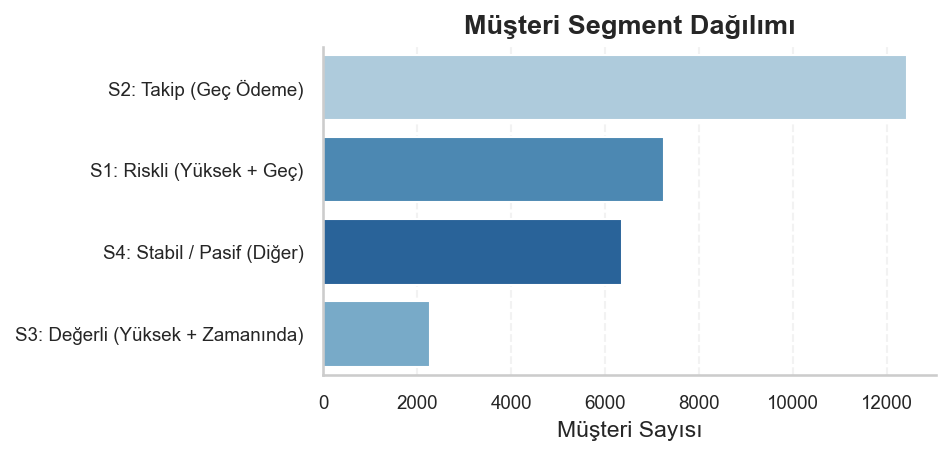

In [76]:
order = seg["segment"].value_counts().index
n = len(order)

cmap = sns.color_palette("Blues", as_cmap=True)
palette = [cmap(0.35 + 0.45 * i/(n-1 if n > 1 else 1)) for i in range(n)]

plt.figure(figsize=(6.5, min(3.6, 1.8 + n * 0.35)), dpi=150)

ax = sns.countplot(
    data=seg,
    y="segment",
    order=order,
    hue="segment",
    palette=palette,
    legend=False
)

ax.set_title("Müşteri Segment Dağılımı", fontsize=13, fontweight="bold", pad=6)
ax.set_xlabel("Müşteri Sayısı", fontsize=11)
ax.set_ylabel("")

ax.grid(axis="x", linestyle="--", alpha=0.25)
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

ax.tick_params(axis="x", labelsize=9)
ax.tick_params(axis="y", labelsize=9)

plt.tight_layout()
save_fig("06_customer_segment_distribution.png") 
plt.show()

In [77]:
df_plot = (
    seg.dropna(subset=["segment"])
       .groupby("segment", as_index=False)
       .agg(**{"Ortalama kWh": ("avg_kwh", "mean")})
       .sort_values("Ortalama kWh", ascending=False)
)

df_plot.head()

,segment,Ortalama kWh
0,S1: Riskli (Yüksek + Geç),244.535388
2,S3: Değerli (Yüksek + Zamanında),202.343453
3,S4: Stabil / Pasif (Diğer),33.985510
1,S2: Takip (Geç Ödeme),27.688024


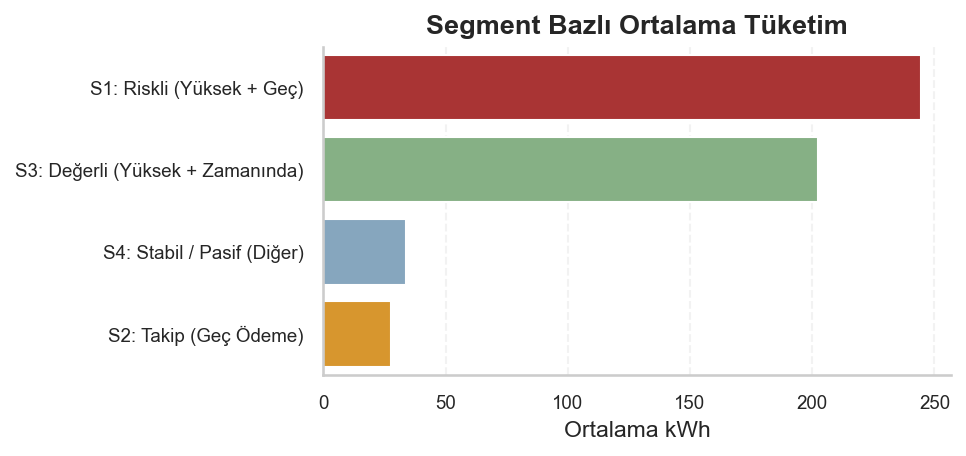

In [78]:
segment_colors = {
    "S1": "#BD2020",   
    "S2": "#F39C12",   
    "S3": "#7FB77E",   
    "S4": "#7DA7C7"    
}

df_plot2 = df_plot.copy()
df_plot2["seg_code"] = df_plot2["segment"].astype(str).str.extract(r"^(S\d+)", expand=False)

fig_h = min(3.8, 1.8 + len(df_plot2) * 0.35)
fig, ax = plt.subplots(figsize=(6.6, fig_h), dpi=150)

sns.barplot(
    data=df_plot2,
    x="Ortalama kWh",
    y="segment",
    hue="seg_code",
    palette=segment_colors,
    dodge=False,
    legend=False,
    ax=ax
)

ax.set_title("Segment Bazlı Ortalama Tüketim", fontsize=13, fontweight="bold", pad=6)
ax.set_xlabel("Ortalama kWh", fontsize=11)
ax.set_ylabel("")

ax.grid(axis="x", linestyle="--", alpha=0.25)

for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

ax.tick_params(axis="x", labelsize=9)
ax.tick_params(axis="y", labelsize=9)

plt.tight_layout()
save_fig("07_segment_avg_consumption.png") 
plt.show()

In [79]:
heat1 = (
    seg.pivot_table(
        index="tuketim_segmenti",
        columns="odeme_durumu",
        values="sozlesme_hesap_no",   
        aggfunc="count",
        fill_value=0
    )
)

heat1 = heat1.div(heat1.sum(axis=1), axis=0) * 100

heat1

odeme_durumu,Geç Ödeme,Zamanında Ödeme,Ödeme Yok
tuketim_segmenti,,,
Düşük Tüketim,60.829049,30.216367,8.954584
Orta Tüketim,72.201393,26.234601,1.564006
Yüksek Tüketim,75.288492,23.661503,1.050005


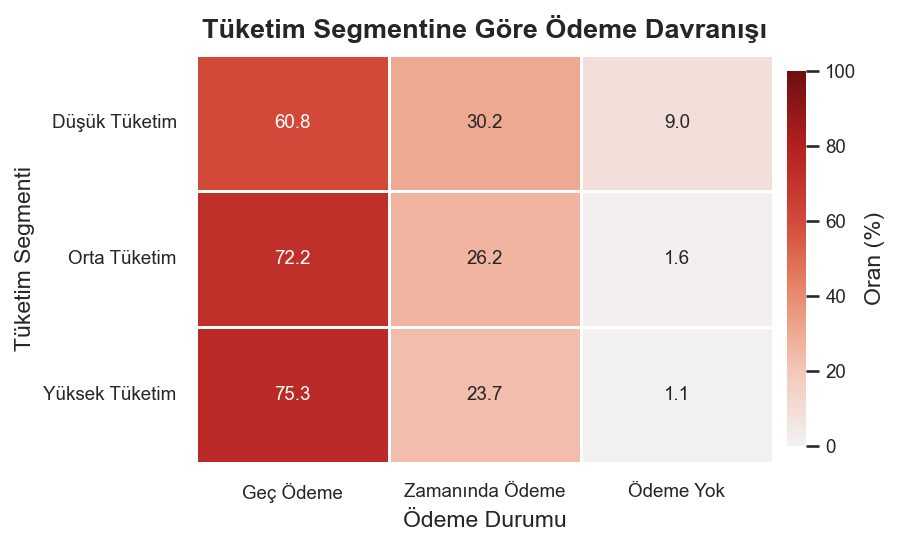

In [80]:
col_order = ["Geç Ödeme", "Zamanında Ödeme", "Ödeme Yok"]

heat1 = (pd.crosstab(seg["tuketim_segmenti"], seg["odeme_durumu"], normalize="index") * 100)
heat1 = heat1.reindex(columns=[c for c in col_order if c in heat1.columns])
heat1 = heat1.reindex(index=["Düşük Tüketim", "Orta Tüketim", "Yüksek Tüketim"])

red_cmap = LinearSegmentedColormap.from_list(
    "true_red", ["#F2F2F2", "#F4C7B9", "#E98C6E", "#D34A3A", "#B32020", "#6E0F0F"]
)

fig, ax = plt.subplots(figsize=(6.2, 3.8), dpi=150)
ax.set_facecolor("#F2F2F2")

sns.heatmap(
    heat1, annot=True, fmt=".1f",
    cmap=red_cmap, vmin=0, vmax=100,
    linewidths=0.6, linecolor="white",
    cbar_kws={"label": "Oran (%)", "shrink": 0.92, "pad": 0.02},
    annot_kws={"fontsize": 9},
    ax=ax
)

ax.set_title("Tüketim Segmentine Göre Ödeme Davranışı", fontweight="bold", pad=8)
ax.set_xlabel("Ödeme Durumu")
ax.set_ylabel("Tüketim Segmenti")

ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="center")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

plt.tight_layout()
save_fig("08_payment_behavior_by_segment.png")
plt.show()

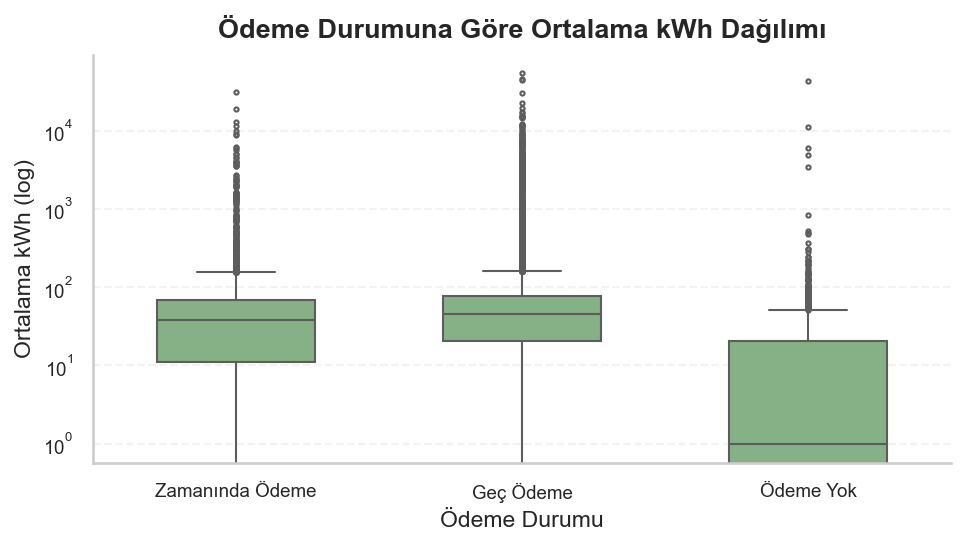

In [81]:
order = ["Zamanında Ödeme", "Geç Ödeme", "Ödeme Yok"]
order = [x for x in order if x in df_risk["odeme_durumu"].unique()]

fig, ax = plt.subplots(figsize=(6.6, 3.8), dpi=150)

sns.boxplot(
    data=df_risk,
    x="odeme_durumu",
    y="ort_kwh",
    order=order,
    color="#7FB77E",
    width=0.55,
    fliersize=2,
    ax=ax
)

ax.set_yscale("log")
ax.set_title("Ödeme Durumuna Göre Ortalama kWh Dağılımı", fontweight="bold", pad=8)
ax.set_xlabel("Ödeme Durumu")
ax.set_ylabel("Ortalama kWh (log)")

ax.grid(axis="y", linestyle="--", alpha=0.25)

for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

ax.tick_params(axis="x", labelrotation=0)

plt.tight_layout()
save_fig("09_consumption_by_payment_boxplot.png")
plt.show()

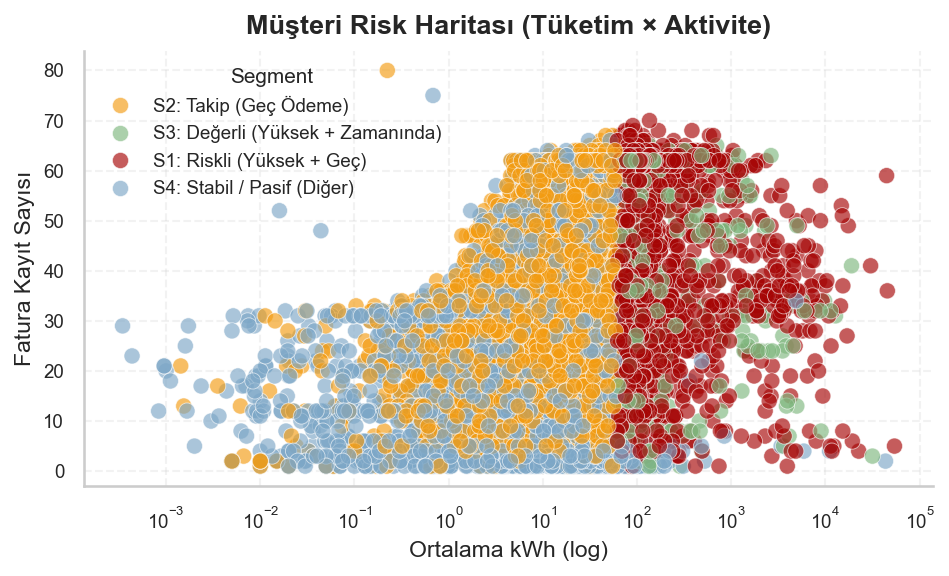

In [82]:
segment_colors = {
    "S1: Riskli (Yüksek + Geç)": "#A60505",   
    "S2: Takip (Geç Ödeme)": "#F39C12",      
    "S3: Değerli (Yüksek + Zamanında)": "#7FB77E",  
    "S4: Stabil / Pasif (Diğer)": "#7DA7C7"   
}

fig, ax = plt.subplots(figsize=(6.5, 4.0), dpi=150)

sns.scatterplot(
    data=seg,
    x="avg_kwh",
    y="n_records",
    hue="segment",
    palette=segment_colors,   
    alpha=0.65,
    s=60,
    edgecolor="white",
    linewidth=0.4,
    ax=ax
)

ax.set_xscale("log")

ax.set_title("Müşteri Risk Haritası (Tüketim × Aktivite)",
             fontsize=13, fontweight="bold", pad=8)
ax.set_xlabel("Ortalama kWh (log)", fontsize=11)
ax.set_ylabel("Fatura Kayıt Sayısı", fontsize=11)

ax.grid(True, linestyle="--", alpha=0.25)

for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

ax.tick_params(axis="x", labelsize=9)
ax.tick_params(axis="y", labelsize=9)

ax.legend(title="Segment", frameon=False, fontsize=9, title_fontsize=10)

plt.tight_layout()
plt.show()

**Müşteri Segment Profil Kartları**

🟥 **S1 — Riskli (Yüksek Tüketim + Geç Ödeme)**

**Profil**
•	Ortalama tüketimi en yüksek gruplardan biri
•	Ancak ödeme gecikmeleri mevcut
•	Şirket için en yüksek finansal risk bu grupta

**Davranış Özeti**
•	Yüksek kWh → yüksek fatura
•	Geç ödeme → nakit akışı riski
•	Az sayıda müşteri olsa bile etkisi büyüktür

**İş Riski**
Bu grup şirketin “kayıp yazabileceği” müşterilerdir.

**Önerilen Aksiyonlar**
•	Otomatik ödeme zorunlu / güçlü teşvik
•	Taksit, teminat veya ödeme planı
•	Son ödeme öncesi erken uyarı sistemi

**Takip KPI’ları**
•	Geç ödeme tekrar oranı
•	Ortalama gecikme süresi
•	Tahsilat oranı (%)

🟧 **S2 — Takip Gerektiren (Geç Ödeme)**

**Profil**
•	Düşük veya orta tüketimli
•	Düzenli geciken ama yüksek borç yaratmayan müşteriler

**Davranış Özeti**
•	Operasyonel yük oluştururlar
•	Çağrı merkezi, SMS, hatırlatma maliyeti üretirler

**İş Riski**
Kârlılığı düşüren “gizli maliyet” bu segmentten gelir.

**Önerilen Aksiyonlar**
•	Otomatik ödeme veya kart tanımlama teşviki
•	Hatırlatma sıklığı optimizasyonu
•	Küçük ödül/ceza mekanizmaları

**Takip KPI’ları**
•	Hatırlatma sonrası ödeme oranı
•	Zamanında ödeme dönüş oranı
•	Operasyon maliyeti / müşteri

🟩 **S3 — Değerli (Yüksek Tüketim + Zamanında Ödeme)**

**Profil**
•	Yüksek tüketim
•	Düzenli ve güvenilir ödeme

**Davranış Özeti**
•	Şirketin en kârlı müşteri kitlesi
•	Düşük tahsilat riski + yüksek gelir

**İş Değeri**
Bu grup şirketin finansal omurgasıdır.

**Önerilen Aksiyonlar**
•	VIP iletişim, öncelikli destek
•	Otomatik ödeme teşviki ile bağlama
•	Sadakat / avantaj programları

**Takip KPI’ları**
•	Müşteri kayıp oranı (churn)
•	Otomatik ödeme oranı
•	Müşteri memnuniyeti

🟦 **S4 — Stabil / Pasif (Diğer)**

**Profil**
•	Düşük–orta tüketim
•	Çoğu zaman zamanında ödeme
•	Net risk veya yüksek değer yok

**Davranış Özeti**
•	Büyük kitle
•	Kârlılığı sınırlı ama stabil

**İş Rolü**
Operasyonel olarak ucuz yönetilmesi gereken kitle

**Önerilen Aksiyonlar**
•	Düşük maliyetli otomatik ödeme
•	Yükselme potansiyeli olanları (tüketimi artan) izleme
•	Dijital kanallara yönlendirme

**Takip KPI’ları**
•	Otomatik ödeme geçiş oranı
•	Segmentten S3’e yükselen müşteri sayısı
•	Hizmet maliyeti / müşteri


**Bulgular**

- Müşteriler tüketim ve ödeme davranışlarına göre anlamlı segmentlere ayrılmaktadır.
- Tüketim seviyesi ile ödeme davranışı arasında belirgin bir ilişki bulunmaktadır.
- Yüksek tüketim ile geç ödeme birleştiğinde tahsilat riski belirgin şekilde artmaktadır. 
- Yüksek tüketim ve zamanında ödeme gösteren müşteriler en değerli gelir grubunu oluşturmaktadır.
- Geç ödeme gösteren düşük–orta tüketimli müşteriler ise operasyonel takip yükünü artırmaktadır.
      
**İş Önerileri**

- Yüksek tüketim + geç ödeme segmenti için taksit, otomatik ödeme ve erken uyarı mekanizmaları uygulanmalıdır.  
- Yüksek tüketim + zamanında ödeme segmenti için sadakat ve teşvik programları geliştirilmelidir.
- Geç ödeyen düşük/orta tüketimli müşteriler için düşük maliyetli hatırlatma ve küçük teşvikler uygulanmalıdır.
- Tahsilat ve iletişim süreçleri segment bazlı önceliklendirilerek operasyonel verim artırılmalıdır.

**5. Tahsilat Performans Analizi**

**Problem Tanımı**

Tahsilat performansı şirketin nakit akışını doğrudan etkiler. Hangi müşteri gruplarının risk oluşturduğunu ve bu riskin hangi koşullarda yoğunlaştığını anlamak, etkin tahsilat ve müşteri yönetimi için kritiktir.

**Hipotezler**

- Yüksek tüketimli müşterilerde geç ödeme riski daha yüksektir.
- Ticari profilin yoğun olduğu gruplarda gecikmeli ödeme oranı daha yüksektir.
- Bazı müşteri ve hesap sınıflarında gecikmeli ödeme davranışı daha yaygındır.

**Analiz**

In [83]:
def clean_columns(df):
    df = df.copy()
    df.columns = df.columns.str.strip()
    return df

def pick_col(df, candidates, name_for_error):
    for c in candidates:
        if c in df.columns:
            return c
    raise KeyError(f"Kolon bulunamadı: {name_for_error}. Adaylar={candidates}")

def std_str(s):
    return s.astype(str).str.strip().str.upper()

def payment_any_positive(df, cols):
    exist = [c for c in cols if c in df.columns]
    if not exist:
        return pd.Series(False, index=df.index)
    x = df[exist].apply(pd.to_numeric, errors="coerce").fillna(0)
    return x.gt(0).any(axis=1)

In [84]:
dfk = clean_columns(df_tahakkuk_all)

k_key = pick_col(dfk, ["sozlesme_hesap_no", "Söz.hsp.(bağımsız)"], "Tahakkuk sözleşme")
k_ilce = pick_col(dfk, ["ilce", "İlçe"], "Tahakkuk ilçe")
k_kwh = pick_col(dfk, ["kwh", "KWH", "kWh"], "Tahakkuk kWh")
k_hs  = None
for cand in ["hesap_sinifi", "Hesap Sınıfı", "Hesap Sinifi"]:
    if cand in dfk.columns:
        k_hs = cand
        break

tah = dfk.rename(columns={k_key:"soz_id", k_ilce:"ilce", k_kwh:"kwh"}).copy()
tah["soz_id"] = tah["soz_id"].astype(str).str.replace(r"\.0$", "", regex=True).str.strip()
tah["ilce"]   = std_str(tah["ilce"])
tah["kwh"]    = pd.to_numeric(tah["kwh"], errors="coerce")

cust_cons = (
    tah.dropna(subset=["kwh"])
       .groupby("soz_id")
       .agg(
           toplam_kwh=("kwh","sum"),
           ort_kwh=("kwh","mean"),
           medyan_kwh=("kwh","median"),
           kayit_sayisi=("kwh","size"),
           ilce=("ilce", lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0]),
       )
       .reset_index()
)

if k_hs is not None:
    tmp = tah.copy()
    tmp[k_hs] = tmp[k_hs].astype(str)
    hs_mode = (
        tmp.groupby("soz_id")[k_hs]
           .agg(lambda s: s.value_counts().index[0] if len(s.dropna()) else np.nan)
           .reset_index(name="hesap_sinifi_baskin")
    )
    cust_cons = cust_cons.merge(hs_mode, on="soz_id", how="left")
else:
    cust_cons["hesap_sinifi_baskin"] = np.nan

cust_cons.head()

,soz_id,toplam_kwh,ort_kwh,medyan_kwh,kayit_sayisi,ilce,hesap_sinifi_baskin
0,1000201265,381.91,14.688846,0.805,26,HAMAMÖZÜ,M001
1,1000410036,2821.30,72.341026,68.990,39,GÜMÜŞHACIKÖY,M001
2,1000551498,5321.04,87.230164,87.680,61,GÖYNÜCEK,M001
3,100060700,1397.62,45.084516,43.550,31,GÖYNÜCEK,T001
4,1000761630,5273.45,85.055645,85.005,62,GÖYNÜCEK,M001


In [85]:
dfp = clean_columns(df_tahsilat_1)

p_key  = pick_col(dfp, ["Söz.hsp.(bağımsız)", "sozlesme_hesap_no"], "Tahsilat1 sözleşme")
p_ilce = pick_col(dfp, ["İlçe", "ilce"], "Tahsilat1 ilçe")

pay = dfp.rename(columns={p_key:"soz_id", p_ilce:"ilce"}).copy()
pay["soz_id"] = pay["soz_id"].astype(str).str.replace(r"\.0$", "", regex=True).str.strip()
pay["ilce"]   = std_str(pay["ilce"])

gec_mask  = payment_any_positive(pay, gec_cols)
zam_mask  = payment_any_positive(pay, zamaninda_cols)

pay["odeme_durumu"] = np.select(
    [gec_mask, zam_mask],
    ["Geç Ödeme", "Zamanında Ödeme"],
    default="Ödeme Yok"
)

priority = pd.Categorical(
    pay["odeme_durumu"],
    categories=["Ödeme Yok", "Zamanında Ödeme", "Geç Ödeme"],
    ordered=True
)

cust_pay = (
    pay.assign(odeme_cat=priority)
       .groupby("soz_id")["odeme_cat"]
       .max()
       .astype(str)
       .reset_index(name="odeme_durumu")
)

cust_pay["odeme_durumu"].value_counts()

odeme_durumu
Geç Ödeme          36869
Zamanında Ödeme    15046
Ödeme Yok            452
Name: count, dtype: int64

In [86]:
df_risk = cust_cons.merge(cust_pay, on="soz_id", how="left")
df_risk["odeme_durumu"] = df_risk["odeme_durumu"].fillna("Ödeme Yok")

df_risk["risk_flag"] = (df_risk["odeme_durumu"] == "Geç Ödeme").astype(int)

q1, q3 = df_risk["toplam_kwh"].quantile([0.25, 0.75])

df_risk["tuketim_segmenti"] = pd.cut(
    df_risk["toplam_kwh"],
    bins=[-np.inf, q1, q3, np.inf],
    labels=["Düşük Tüketim", "Orta Tüketim", "Yüksek Tüketim"]
).astype(str)

df_risk["kritik_risk_flag"] = (
    (df_risk["odeme_durumu"] == "Geç Ödeme") &
    (df_risk["tuketim_segmenti"] == "Yüksek Tüketim")
).astype(int)

df_risk.head()

,soz_id,toplam_kwh,ort_kwh,medyan_kwh,kayit_sayisi,ilce,hesap_sinifi_baskin,odeme_durumu,risk_flag,tuketim_segmenti,kritik_risk_flag
0,1000201265,381.91,14.688846,0.805,26,HAMAMÖZÜ,M001,Geç Ödeme,1,Düşük Tüketim,0
1,1000410036,2821.30,72.341026,68.990,39,GÜMÜŞHACIKÖY,M001,Zamanında Ödeme,0,Orta Tüketim,0
2,1000551498,5321.04,87.230164,87.680,61,GÖYNÜCEK,M001,Geç Ödeme,1,Yüksek Tüketim,1
3,100060700,1397.62,45.084516,43.550,31,GÖYNÜCEK,T001,Geç Ödeme,1,Orta Tüketim,0
4,1000761630,5273.45,85.055645,85.005,62,GÖYNÜCEK,M001,Zamanında Ödeme,0,Yüksek Tüketim,0


In [87]:
if "pivot_risk" not in globals() or not isinstance(pivot_risk, pd.DataFrame):
    print("pivot_risk yok veya sorun var, yeniden üretiliyor...")

    base = None
    for name in ["df_merged", "df_risk", "seg", "seg_df"]:
        if name in globals():
            base = globals()[name].copy()
            print("Kullanılan tablo:", name)
            break
    if base is None:
        raise NameError("pivot_risk üretmek için df_merged / df_risk / seg bulunamadı.")

    col_kwh = next(c for c in ["toplam_kwh","avg_kwh","kwh"] if c in base.columns)
    col_hs  = next(c for c in ["hesap_sinifi","hesap_sinifi_baskin"] if c in base.columns)
    col_risk= next(c for c in ["riskli_mi","risk_flag","kritik_risk_flag"] if c in base.columns)

    hm = base.dropna(subset=[col_kwh, col_hs]).copy()
    hm[col_kwh] = pd.to_numeric(hm[col_kwh], errors="coerce")
    hm = hm.dropna(subset=[col_kwh])

    hm[col_risk] = pd.to_numeric(hm[col_risk], errors="coerce").fillna(0).astype(int)

    hm["tuketim_segmenti"] = pd.qcut(
        hm[col_kwh],
        q=min(4, hm[col_kwh].nunique()),
        labels=["Düşük","Orta","Yüksek","Çok Yüksek"][:min(4, hm[col_kwh].nunique())]
    )

    pivot_risk = (
        hm.pivot_table(
            index=col_hs,
            columns="tuketim_segmenti",
            values=col_risk,
            observed=True,
            aggfunc="mean"
        ).fillna(0) * 100
    )

stacked = (
    pivot_risk
    .stack()
    .rename("gec_odeme_orani_%")
    .reset_index()
    .sort_values("gec_odeme_orani_%", ascending=False)
)

top5 = stacked.head(5)
top5

,hesap_sinifi_baskin,tuketim_segmenti,gec_odeme_orani_%
3,1,Çok Yüksek,100.0
6,3,Yüksek,100.0
10,4,Yüksek,100.0
11,4,Çok Yüksek,100.0
15,6,Çok Yüksek,100.0


In [88]:
if "df_hm" not in globals() or not isinstance(df_hm, pd.DataFrame):
    base = None
    for name in ["df_risk", "seg", "df_merged", "hm"]:  
        if name in globals() and isinstance(globals()[name], pd.DataFrame):
            base = globals()[name].copy()
            print("Kullanılan tablo:", name)
            break
    if base is None:
        raise NameError("df_hm üretmek için df_risk / seg / df_merged / hm bulunamadı.")

    col_hs = next((c for c in ["hesap_sinifi_baskin","hesap_sinifi"] if c in base.columns), None)
    col_seg = next((c for c in ["tuketim_segmenti","tuketim_segmenti_baskin"] if c in base.columns), None)
    col_risk = next((c for c in ["risk_flag","riskli_mi","kritik_risk_flag"] if c in base.columns), None)

    missing = [x for x in ["hesap_sinifi_baskin/türü", "tuketim_segmenti", "risk_flag"]
               if (x.startswith("hesap") and col_hs is None) or (x=="tuketim_segmenti" and col_seg is None) or (x=="risk_flag" and col_risk is None)]
    if missing:
        raise KeyError(f"Gerekli kolonlar yok: {missing}\nMevcut kolonlar: {list(base.columns)}")

    df_hm = base[[col_hs, col_seg, col_risk]].rename(
        columns={col_hs: "hesap_sinifi_baskin", col_seg: "tuketim_segmenti", col_risk: "risk_flag"}
    ).copy()

    df_hm["risk_flag"] = pd.to_numeric(df_hm["risk_flag"], errors="coerce").fillna(0)
    df_hm["risk_flag"] = (df_hm["risk_flag"] > 0).astype(int)

summary = (
    df_hm
    .groupby(["hesap_sinifi_baskin", "tuketim_segmenti"], observed=True)
    .agg(
        n=("risk_flag", "size"),
        gec_odeme_orani=("risk_flag", "mean")
    )
    .assign(gec_odeme_orani=lambda d: (d["gec_odeme_orani"]*100).round(1))
    .reset_index()
    .sort_values(["gec_odeme_orani","n"], ascending=[False, False])
)

summary.head(15)

,hesap_sinifi_baskin,tuketim_segmenti,n,gec_odeme_orani
5,4,Yüksek Tüketim,23,100.0
13,M004,Orta Tüketim,8,100.0
25,T008,Yüksek Tüketim,5,100.0
34,T021,Yüksek Tüketim,4,100.0
24,T008,Orta Tüketim,3,100.0
39,TA02,Orta Tüketim,1,100.0
28,T013,Yüksek Tüketim,43,97.7
27,T013,Orta Tüketim,14,92.9
40,TA02,Yüksek Tüketim,53,90.6
22,T002,Yüksek Tüketim,35,88.6


Banka Tahsilatı Oranı: %98.73  |  Banka adet: 628933 / 636993


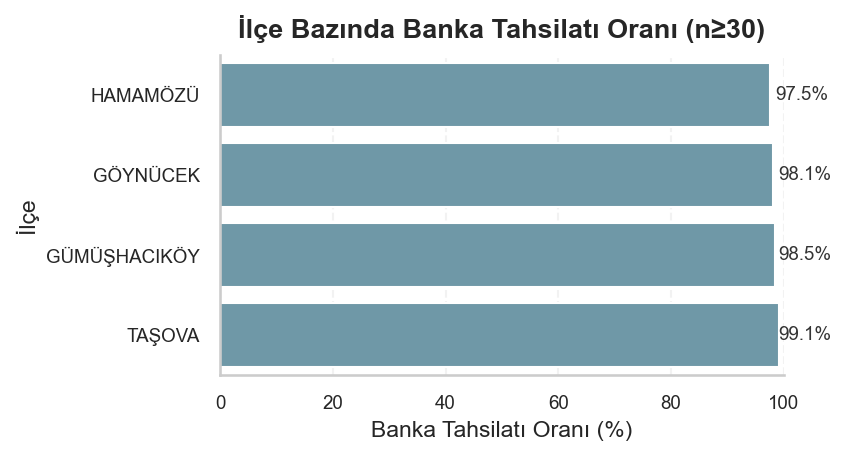

In [89]:
def pick_col(df, candidates, label):
    for c in candidates:
        if c in df.columns:
            return c
    raise KeyError(
        f"{label} kolonu bulunamadı. Adaylar: {candidates}. "
        f"Mevcut kolonlar: {list(df.columns)}"
    )

col_ilce  = pick_col(df_tahsilat, ["İlçe", "ilce", "ILCE", "İLÇE"], "İlçe")
col_banka = pick_col(df_tahsilat, ["Banka Tahsilatı", "Banka_tahsilati", "BANKA TAHSİLATI"], "Banka Tahsilatı")

use_positive_only = False

banka_series = df_tahsilat[col_banka]

if use_positive_only:
    banka_num = pd.to_numeric(banka_series, errors="coerce").fillna(0)
    is_banka = banka_num.gt(0)
else:
    is_banka = banka_series.notna()

banka_oran = is_banka.mean() * 100
banka_adet = int(is_banka.sum())
toplam_adet = len(df_tahsilat)

print(f"Banka Tahsilatı Oranı: %{banka_oran:.2f}  |  Banka adet: {banka_adet} / {toplam_adet}")

ilce_banka = (
    df_tahsilat.assign(
        is_banka=is_banka,
        ilce_std=df_tahsilat[col_ilce].astype(str).str.strip().str.upper()
    )
    .groupby("ilce_std")
    .agg(banka_orani_pct=("is_banka", lambda s: s.mean() * 100),
         adet=("is_banka", "size"))
    .reset_index()
)

MIN_N = 30
TOP_N = 15

ilce_banka_f = ilce_banka[ilce_banka["adet"] >= MIN_N].copy()
ilce_banka_f = ilce_banka_f.sort_values("banka_orani_pct", ascending=False).head(TOP_N)

plot_df = ilce_banka_f.sort_values("banka_orani_pct", ascending=True)

fig_h = min(4.2, 1.8 + len(plot_df) * 0.35)
fig, ax = plt.subplots(figsize=(5.8, fig_h), dpi=150)

sns.barplot(
    data=plot_df,
    x="banka_orani_pct",
    y="ilce_std",
    color="#669CB0",
    ax=ax
)

ax.set_title(f"İlçe Bazında Banka Tahsilatı Oranı (n≥{MIN_N})",
             fontsize=13, fontweight="bold", pad=8)
ax.set_xlabel("Banka Tahsilatı Oranı (%)", fontsize=11)
ax.set_ylabel("İlçe", fontsize=11)

ax.set_xlim(0, 100)
ax.grid(axis="x", linestyle="--", alpha=0.25)

for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

ax.tick_params(axis="x", labelsize=9)
ax.tick_params(axis="y", labelsize=9)

for i, v in enumerate(plot_df["banka_orani_pct"].values):
    ax.text(min(v + 1.0, 99.0), i, f"{v:.1f}%", va="center", fontsize=9, color="#333333")

plt.tight_layout()
save_fig("10_bank_collection_rate_by_district.png") 
plt.show()

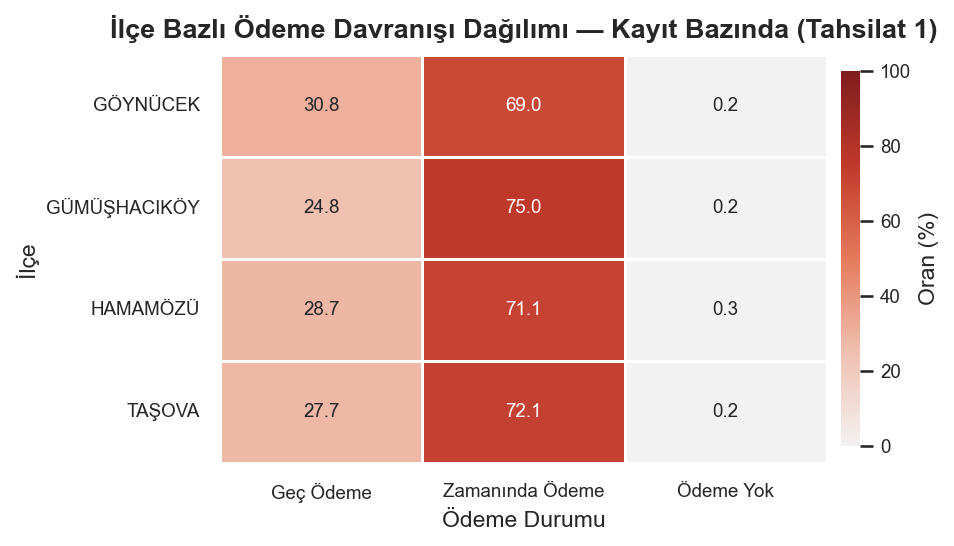

In [90]:
col_order = ["Geç Ödeme", "Zamanında Ödeme", "Ödeme Yok"]

heat2 = (pd.crosstab(pay["ilce"], pay["odeme_durumu"], normalize="index") * 100)
heat2 = heat2.reindex(columns=[c for c in col_order if c in heat2.columns])

red_cmap = LinearSegmentedColormap.from_list(
    "true_red", ["#F2F2F2", "#F0C0B0", "#E57A5C", "#C0392B", "#7F1D1D"]
)

fig, ax = plt.subplots(figsize=(6.6, 3.8), dpi=150)
ax.set_facecolor("#F2F2F2")

sns.heatmap(
    heat2, annot=True, fmt=".1f",
    cmap=red_cmap, vmin=0, vmax=100,
    linewidths=0.6, linecolor="white",
    cbar_kws={"label": "Oran (%)", "shrink": 0.92, "pad": 0.02},
    annot_kws={"fontsize": 9},
    ax=ax
)

ax.set_title("İlçe Bazlı Ödeme Davranışı Dağılımı — Kayıt Bazında (Tahsilat 1)",
             fontweight="bold", pad=8)
ax.set_xlabel("Ödeme Durumu")
ax.set_ylabel("İlçe")

ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="center")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.show()

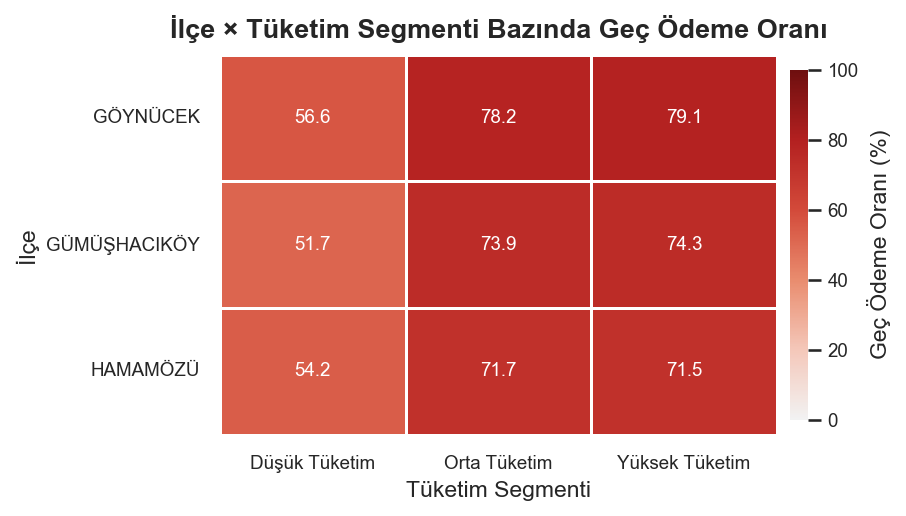

In [91]:
seg_order = ["Düşük Tüketim", "Orta Tüketim", "Yüksek Tüketim"]

risk_pivot = (
    df_risk
    .groupby(["ilce", "tuketim_segmenti"])["risk_flag"]
    .mean()
    .mul(100)
    .reset_index()
    .pivot(index="ilce", columns="tuketim_segmenti", values="risk_flag")
    .reindex(columns=seg_order)
)

red_cmap = LinearSegmentedColormap.from_list(
    "true_red", ["#F2F2F2", "#F4C7B9", "#E98C6E", "#D34A3A", "#B32020", "#6E0F0F"]
)

fig, ax = plt.subplots(figsize=(6.2, 3.6), dpi=150)
ax.set_facecolor("#F2F2F2")

sns.heatmap(
    risk_pivot, annot=True, fmt=".1f",
    cmap=red_cmap, vmin=0, vmax=100,
    linewidths=0.6, linecolor="white",
    cbar_kws={"label": "Geç Ödeme Oranı (%)", "shrink": 0.92, "pad": 0.02},
    annot_kws={"fontsize": 9},
    ax=ax
)

ax.set_title("İlçe × Tüketim Segmenti Bazında Geç Ödeme Oranı",
             fontweight="bold", pad=8)
ax.set_xlabel("Tüketim Segmenti")
ax.set_ylabel("İlçe")

ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="center")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

plt.tight_layout()
save_fig("11_late_payment_rate_by_district_segment.png")
plt.show()

In [92]:
needed = ["hesap_sinifi_baskin", "tuketim_segmenti", "risk_flag"]
missing = [c for c in needed if c not in df_risk.columns]
if missing:
    raise KeyError(f"df_risk içinde eksik kolonlar var: {missing}. Mevcut kolonlar: {list(df_risk.columns)}")

print("df_risk hazır. Hesap sınıfı sayısı:", df_risk["hesap_sinifi_baskin"].nunique())
print("Tüketim segmentleri:", df_risk["tuketim_segmenti"].unique())

df_risk hazır. Hesap sınıfı sayısı: 36
Tüketim segmentleri: ['Düşük Tüketim' 'Orta Tüketim' 'Yüksek Tüketim']


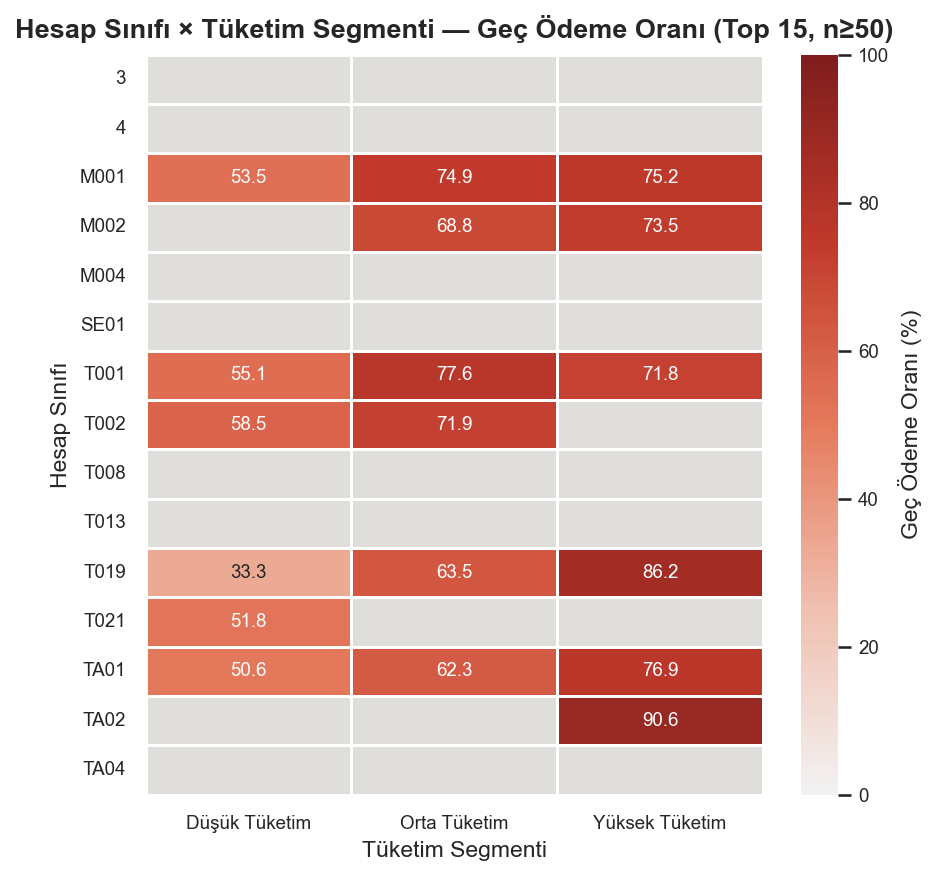

In [93]:
TOP_N = 15
MIN_N = 50
ORDER_SEG = ["Düşük Tüketim", "Orta Tüketim", "Yüksek Tüketim"]

df_hm = df_risk.dropna(subset=["hesap_sinifi_baskin", "tuketim_segmenti", "risk_flag"]).copy()

top_hs = df_hm["hesap_sinifi_baskin"].value_counts().head(TOP_N).index
df_hm = df_hm[df_hm["hesap_sinifi_baskin"].isin(top_hs)]

pivot_rate = (
    df_hm
    .groupby(["hesap_sinifi_baskin", "tuketim_segmenti"])["risk_flag"]
    .mean()
    .mul(100)
    .reset_index()
    .pivot(index="hesap_sinifi_baskin", columns="tuketim_segmenti", values="risk_flag")
)

existing_seg = [s for s in ORDER_SEG if s in pivot_rate.columns]
other_seg = [c for c in pivot_rate.columns if c not in existing_seg]
pivot_rate = pivot_rate[existing_seg + other_seg]

pivot_n = (
    df_hm
    .groupby(["hesap_sinifi_baskin", "tuketim_segmenti"])
    .size()
    .reset_index(name="n")
    .pivot(index="hesap_sinifi_baskin", columns="tuketim_segmenti", values="n")
    .reindex(index=pivot_rate.index, columns=pivot_rate.columns)
)

mask = (pivot_n < MIN_N) | pivot_rate.isna()

red_cmap = LinearSegmentedColormap.from_list(
    "true_red",
    ["#F2F2F2", "#F0C0B0", "#E57A5C", "#C0392B", "#7F1D1D"]
)

empty_gray = "#E0DEDA"
red_cmap.set_bad(color=empty_gray)

n_rows = pivot_rate.shape[0]
fig_h = min(6.0, 2.2 + n_rows * 0.33)
fig, ax = plt.subplots(figsize=(6.2, fig_h), dpi=150)

ax.set_facecolor(empty_gray)

sns.heatmap(
    pivot_rate,
    mask=mask,
    annot=True,
    fmt=".1f",
    cmap=red_cmap,
    vmin=0, vmax=100,
    linewidths=0.6, linecolor="white",
    cbar_kws={"label": "Geç Ödeme Oranı (%)"},
    annot_kws={"fontsize": 9},
    ax=ax
)

ax.set_title(f"Hesap Sınıfı × Tüketim Segmenti — Geç Ödeme Oranı (Top {TOP_N}, n≥{MIN_N})",
             fontsize=13, fontweight="bold", pad=8)
ax.set_xlabel("Tüketim Segmenti", fontsize=11)
ax.set_ylabel("Hesap Sınıfı", fontsize=11)

ax.tick_params(axis="x", labelsize=9, rotation=0)
ax.tick_params(axis="y", labelsize=9, rotation=0)

for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.show()

**Tahsilat Strateji Tablosu**

Aşağıda müşteri risk profillerine göre tahsilat ve ilişki yönetimi stratejileri özetlenmiştir.

| Profil | Amaç | Ne Yapılmalı | Neden |
|--------|------|-------------|-------|
| 🟥 **RP1 — Kritik Riskli** | Nakit açığını kapat | Otomatik ödeme, erken uyarı SMS, taksitlendirme | Büyük fatura + gecikme en yüksek finansal riski oluşturur |
| 🟧 **RP2 — Takip Gerektiren** | Gecikme alışkanlığını kır | Hatırlatma sıklığı artırma, dijital ödeme teşviki | Müşteri sayısı yüksek, manuel takip maliyetlidir |
| 🟩 **RP3 — Güvenilir & Yüksek Değerli** | Kaybetmemek | Sorunsuz ödeme deneyimi, sadakat teşvikleri | Nakit akışının temel kaynağı |
| 🟦 **RP4 — Düşük Riskli / Pasif** | Otomatikleştirmek | Self-servis, minimum temas | Operasyon maliyetini düşürmek gerekir |

**Bulgular**

- Geç ödeme davranışı tüm müşterilere eşit dağılmamakta, belirli segmentlerde yoğunlaşmaktadır.
- Ticari müşterilerde risk daha yüksektir.  
- Özellikle yüksek tüketim + geç ödeme kombinasyonu, tahsilat riski açısından en kritik grubu oluşturmaktadır. 
- Müşteri profili (hesap sınıfı, mesken oranı) ve ödeme kanalı kullanımı (banka tahsilatı) riskin yorumlanmasında belirleyici faktörlerdir.
- Banka tahsilatı oranı ve müşteri profili, ödeme davranışını anlamada önemli tamamlayıcı göstergelerdir.
- Bu çalışma sonucunda **riskli müşteri**; Ödeme davranışları nedeniyle şirketin tahsilat ve nakit akışı üzerinde belirsizlik yaratan müşterilerdir; özellikle yüksek tüketimli ve geç ödeyen müşteriler en kritik risk grubunu oluşturur
  
**İş Önerileri**

- Riskli segmentler için otomatik hatırlatma ve yapılandırılmış ödeme planları uygulanmalıdır.
- Ticari ve yüksek riskli müşteriler için teminatlı veya farklı sözleşme modelleri değerlendirilebilir.
- Yüksek riskli müşteriler erken uyarı sistemleriyle (SMS, bildirim, ödeme önerisi) proaktif olarak yönetilmelidir. 
- Banka tahsilatının güçlü olduğu ilçelerde otomatik ödeme talimatı teşviki, gecikmeyi azaltacak şekilde optimize edilebilir.  
- Tahsilat ve iletişim süreçleri müşteri segmentlerine göre farklılaştırılarak operasyonel verim artırılmalıdır.
- Yüksek değerli ve düzenli ödeyen müşteriler sadakat ve teşvik programlarıyla korunmalıdır.

**6. Genel Değerlendirme**

- Bu analiz, enerji tüketimi ve ödeme davranışlarının ilçe ve müşteri segmentleri arasında belirgin biçimde farklılaştığını göstermektedir. Hesap sınıfı yapısı (özellikle mesken–ticari dağılımı) ve mevsimsellik, ilçeler arası tüketim farklarını açıklayan temel faktörler olarak öne çıkmaktadır.

- Müşteri segmentasyonu, yüksek tüketim + gecikmeli ödeme kombinasyonunun tahsilat riski açısından en kritik grup olduğunu ortaya koymuştur. Buna karşılık, yüksek tüketim + zamanında ödeme segmenti nakit akışı ve gelir açısından en değerli müşteri kitlesidir.

- Banka tahsilatı oranları gibi ödeme kanalı göstergeleri, tahsilat altyapısının gücünü yansıtan tamamlayıcı sinyaller sunmaktadır. Genel olarak bulgular, ilçe ve segment bazlı iletişim, ödeme planı ve erken uyarı stratejilerinin veri destekli tasarlanmasının önemli iş değeri yaratacağını göstermektedir.